In [1]:
import os
import pandas as pd
from pycytominer import aggregate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as ss
import numpy as np
#import wget
from venn import venn
import json
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

%matplotlib inline

In [2]:
# Set data input folder
data_input_folder = "inputs_data"

# Set image input folder
image_input_folder = "inputs_images"

# Set output folder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

# Fig 5A, Extended Data 9A

In [5]:
# Adapted from tutorial https://github.com/mousepixels/sanbomics_scripts/blob/main/GO_in_python.ipynb
# https://www.youtube.com/watch?v=ONiWugVEf2s

# Download NCBI data
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo") # Dictionary of GO terms and their metadata

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2023-04-01) 46,575 Terms


In [10]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606]) # 9606 = Human
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc() # Dictionary of dictionaries

HMS:0:00:04.146793 342,553 annotations, 20,749 genes, 18,982 GOs, 1 taxids READ: gene2go 


In [8]:
# Download geneID to gene name lookup
if not os.path.exists(os.path.join(data_input_folder,"Homo_sapiens_gene_info.gz")):
    wget.download(
        "https://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz",
        "Homo_sapiens_gene_info.gz",
    )
ncbi_df = pd.read_csv(os.path.join(data_input_folder,"Homo_sapiens_gene_info.gz"), sep="\t")
ncbi_df = ncbi_df.loc[:, ["Symbol", "description", "GeneID"]]
ncbi_df = (
    ncbi_df.rename(columns={"Symbol": "Gene", "description": "FullName"})
    .drop_duplicates(subset=["Gene"])
)
ncbi_df.head()

,Gene,FullName,GeneID
0,A1BG,alpha-1-B glycoprotein,1
1,A2M,alpha-2-macroglobulin,2
2,A2MP1,alpha-2-macroglobulin pseudogene 1,3
3,NAT1,N-acetyltransferase 1,9
4,NAT2,N-acetyltransferase 2,10


In [9]:
with open("../Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    express = json.load(f)
    HeLa_expressed_gene_list = express['expressed_genes']
with open("../Hit_Calling/outputs/A549_CCLE_expression_summary.json") as f:
    express = json.load(f)
    A549_expressed_gene_list = express['expressed_genes']
HeLa_expressed_df = pd.DataFrame()
HeLa_expressed_df['Gene'] = HeLa_expressed_gene_list
HeLa_expressed_df = HeLa_expressed_df.merge(ncbi_df, on='Gene')
A549_expressed_df = pd.DataFrame()
A549_expressed_df['Gene'] = A549_expressed_gene_list
A549_expressed_df = A549_expressed_df.merge(ncbi_df, on='Gene')

HeLa_expressed_df.head()

,Gene,FullName,GeneID
0,A1BG,alpha-1-B glycoprotein,1
1,A2M,alpha-2-macroglobulin,2
2,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",53947
3,AAAS,aladin WD repeat nucleoporin,8086
4,AACS,acetoacetyl-CoA synthetase,65985


In [13]:
GO_items_HeLa = []
GO_items_A549 = []
for df,GO_items in [(HeLa_expressed_df,GO_items_HeLa),(A549_expressed_df,GO_items_A549)]:
    # Initialize GO object
    goeaobj = GOEnrichmentStudyNS(
            df['GeneID'].to_list(), # list of expressed genes
            ns2assoc, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh']) # default multipletest correction method

    # Make list of go terms
    temp = goeaobj.ns2objgoea['BP'].assoc
    for item in temp:
        GO_items += temp[item]
    temp = goeaobj.ns2objgoea['CC'].assoc
    for item in temp:
        GO_items += temp[item]
    temp = goeaobj.ns2objgoea['MF'].assoc
    for item in temp:
        GO_items += temp[item]


Load BP Ontology Enrichment Analysis ...
 87% 13,542 of 15,478 population items found in association

Load CC Ontology Enrichment Analysis ...
 92% 14,286 of 15,478 population items found in association

Load MF Ontology Enrichment Analysis ...
 90% 14,007 of 15,478 population items found in association

Load BP Ontology Enrichment Analysis ...
 87% 13,877 of 15,876 population items found in association

Load CC Ontology Enrichment Analysis ...
 92% 14,636 of 15,876 population items found in association

Load MF Ontology Enrichment Analysis ...
 90% 14,345 of 15,876 population items found in association


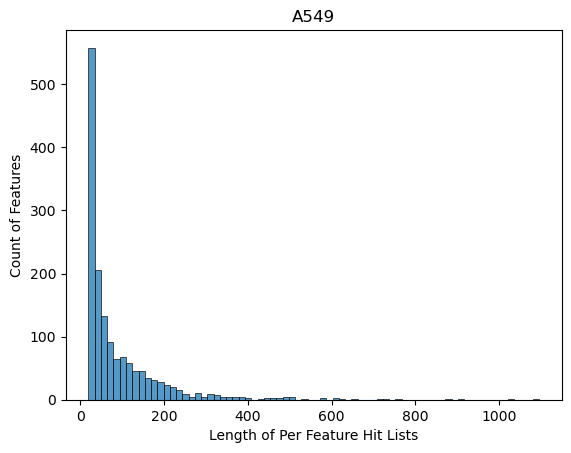

In [94]:
def make_all_top_dict(dataset):
    all_top_dict = {}
    # Create dictionary of all features and their top most significant genes
    df = pd.read_csv(f'../Hit_Calling/outputs/{dataset}_significant_features_mann_whitney_p_values.csv.gz')
    df = df.loc[df['Gene']!='sig_gene_count']
    feat_list = [x for x in df.columns if 'Gene' not in x]
    df_len = pd.DataFrame(columns=['Feature','top_length'])
    for feat in feat_list:
        df_top = df.loc[:,['Gene', feat]].nsmallest(20, feat, keep='all')
        # make dictionary for analysis
        all_top_dict[feat] = df_top['Gene'].to_list()
        # make df for plot
        df_len = pd.concat([df_len,pd.DataFrame({'Feature':[feat],'top_length':[len(all_top_dict[feat])]})],ignore_index=True)
    
    plt.clf()
    ax = sns.histplot(df_len,x='top_length')
    ax.set(xlabel='Length of Per Feature Hit Lists', ylabel='Count of Features', title=dataset)
    plt.savefig(os.path.join(output_folder,f"per_feature_hit_list_lengths_{dataset}.png"))
    return all_top_dict

all_top_dict_HeLa_DMEM = make_all_top_dict('HeLa_DMEM')
all_top_dict_HeLa_HPLM = make_all_top_dict('HeLa_HPLM')
all_top_dict_A549 = make_all_top_dict('A549')

In [ ]:
# Skip this time-intensive enrichment analysis by directly loading output .csvs in next cell

def make_GO_df(dataset, all_top_dict, expressed_df):
    GO_df = pd.DataFrame()
    p_value = .05 / len(all_top_dict.keys()) # include Bonferroni correction in p-value cutoff
    for feat in list(all_top_dict.keys()):
        feat_genes = all_top_dict[feat]
        feat_geneids = expressed_df.loc[expressed_df['Gene'].isin(feat_genes),'GeneID']
        goea_results_all = goeaobj.run_study(feat_geneids)
        # only append feature results to df if there is any significant enrichment
        goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < p_value]
        for sig_res in goea_results_sig:
            GO_df = pd.concat([GO_df,pd.DataFrame([{'Feature':feat,
                            'num_feat_genes':len(feat_genes),
                            'num_feat_ids':len(feat_geneids),
                            'GO':sig_res.GO,
                            'term':sig_res.goterm.name,
                            'class':sig_res.goterm.namespace,
                            'p':sig_res.p_uncorrected,
                            'p_corr':sig_res.p_fdr_bh,
                            'n_genes':sig_res.ratio_in_study[0],
                            'n_study':sig_res.ratio_in_study[1],
                            'n_go':GO_items.count(sig_res.GO),
                            'study_geneIDs':goea_results_sig[0].study_items}])],
                                ignore_index=True)
    GO_df.to_csv(os.path.join(output_folder,f'GO_enrichment_per_feature_20plus_{dataset}.csv'))
    return GO_df
    
GO_df_HeLa_DMEM = make_GO_df('HeLa_DMEM',all_top_dict_HeLa_DMEM, HeLa_expressed_df)
GO_df_HeLa_HPLM = make_GO_df('HeLa_HPLM',all_top_dict_HeLa_HPLM,HeLa_expressed_df)
GO_df_A549 = make_GO_df('A549',all_top_dict_A549,A549_expressed_df)

In [30]:
# Bypass enrichment by directly loading GO enrichment dataframes
GO_df_HeLa_HPLM = pd.read_csv(os.path.join(output_folder,'GO_enrichment_per_feature_20plus_HeLa_HPLM.csv'))
GO_df_HeLa_DMEM = pd.read_csv(os.path.join(output_folder,'GO_enrichment_per_feature_20plus_HeLa_DMEM.csv'))
GO_df_A549 = pd.read_csv(os.path.join(output_folder,'GO_enrichment_per_feature_20plus_A549.csv'))

In [31]:
for dataset, all_top_dict, GO_df in [
    ('HeLa_DMEM',all_top_dict_HeLa_DMEM,GO_df_HeLa_DMEM),
    ('HeLa_HPLM',all_top_dict_HeLa_HPLM,GO_df_HeLa_HPLM),
    ('A549',all_top_dict_A549,GO_df_A549)
    ]:
    print (f'For dataset {dataset}:')
    print (f'Number of tested features: {len(all_top_dict.keys())}')
    print (f'Number of features with GO enrichment: {len(GO_df["Feature"].unique())}')
    print (f'Number of features with GO-BP enrichment: {len(GO_df.loc[GO_df["class"]=="biological_process"]["Feature"].unique())}')
    print (f'Number of features with GO-CC enrichment: {len(GO_df.loc[GO_df["class"]=="cellular_component"]["Feature"].unique())}')
    print (f'Number of features with GO-MF enrichment: {len(GO_df.loc[GO_df["class"]=="molecular_function"]["Feature"].unique())}')
    

For dataset HeLa_DMEM:
Number of tested features: 1597
Number of features with GO enrichment: 496
Number of features with GO-BP enrichment: 316
Number of features with GO-CC enrichment: 436
Number of features with GO-MF enrichment: 253
For dataset HeLa_HPLM:
Number of tested features: 1705
Number of features with GO enrichment: 441
Number of features with GO-BP enrichment: 326
Number of features with GO-CC enrichment: 420
Number of features with GO-MF enrichment: 209
For dataset A549:
Number of tested features: 1520
Number of features with GO enrichment: 35
Number of features with GO-BP enrichment: 12
Number of features with GO-CC enrichment: 28
Number of features with GO-MF enrichment: 24


In [97]:
color_dict = {'ConA':'orchid','WGA':'lightblue','Mito':'lightcoral','Phalloidin':'lightgreen','DAPI':'cornflowerblue','NoChannel':'lightgrey'}
channel_dict = {'ConA':'ER','WGA':'Golgi/Membrane','Mito':'Mito','Phalloidin':'Actin','DAPI':'DNA','NoChannel':'Channel Independent'}

def make_per_channel_dict(dataset, all_top_dict, GO_df):
    per_channel_dict = {'feature_set':{},'enriched':{},'feature_set_num':{},'enriched_num':{}}
    print (f'For dataset {dataset}:')
    for channel in color_dict.keys():
        if channel != 'NoChannel':
            list_in_feature_set = [x for x in all_top_dict.keys() if channel.lower() in x.lower() and 'Correlation' not in x]
        else:
            list_in_feature_set = [x for x in all_top_dict.keys() if not any(c in x for c in color_dict.keys()) and 'Correlation' not in x]
        per_channel_dict['feature_set'][channel] = list_in_feature_set
        per_channel_dict['feature_set_num'][channel] = len(list_in_feature_set)
        if channel != 'NoChannel':
            list_enriched = list(GO_df.loc[GO_df['Feature'].str.contains(channel)]['Feature'].unique())
        else:
            list_enriched = list(GO_df.loc[~GO_df['Feature'].str.contains('|'.join(channel_dict.keys()))]['Feature'].unique())
        per_channel_dict['enriched'][channel] = list_enriched
        per_channel_dict['enriched_num'][channel] = len(list_enriched)
        print (f"There are {len(list_enriched)} {channel} features with GO enrichment out of {len(list_in_feature_set)} in feature set (excluding Correlation features)")
    return per_channel_dict

per_channel_dict_HeLa_DMEM = make_per_channel_dict('HeLa_DMEM',all_top_dict_HeLa_DMEM,GO_df_HeLa_DMEM)
per_channel_dict_HeLa_HPLM = make_per_channel_dict('HeLa_HPLM',all_top_dict_HeLa_HPLM,GO_df_HeLa_HPLM)
per_channel_dict_A549 = make_per_channel_dict('A549',all_top_dict_A549,GO_df_A549)


For dataset HeLa_DMEM:
There are 46 ConA features with GO enrichment out of 168 in feature set (excluding Correlation features)
There are 130 WGA features with GO enrichment out of 228 in feature set (excluding Correlation features)
There are 102 Mito features with GO enrichment out of 316 in feature set (excluding Correlation features)
There are 108 Phalloidin features with GO enrichment out of 180 in feature set (excluding Correlation features)
There are 126 DAPI features with GO enrichment out of 294 in feature set (excluding Correlation features)
There are 18 NoChannel features with GO enrichment out of 266 in feature set (excluding Correlation features)
For dataset HeLa_HPLM:
There are 19 ConA features with GO enrichment out of 192 in feature set (excluding Correlation features)
There are 99 WGA features with GO enrichment out of 271 in feature set (excluding Correlation features)
There are 126 Mito features with GO enrichment out of 332 in feature set (excluding Correlation featu

<Figure size 640x480 with 0 Axes>

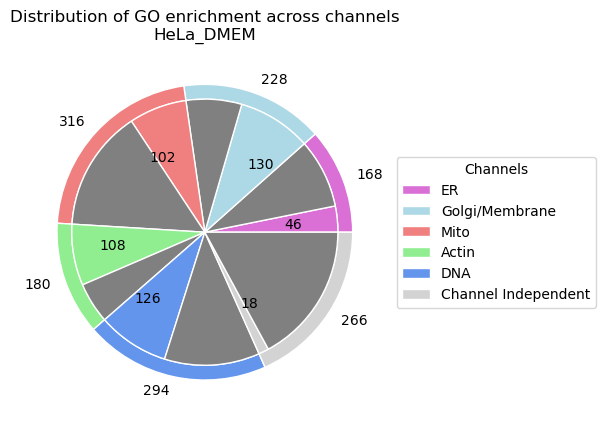

<Figure size 640x480 with 0 Axes>

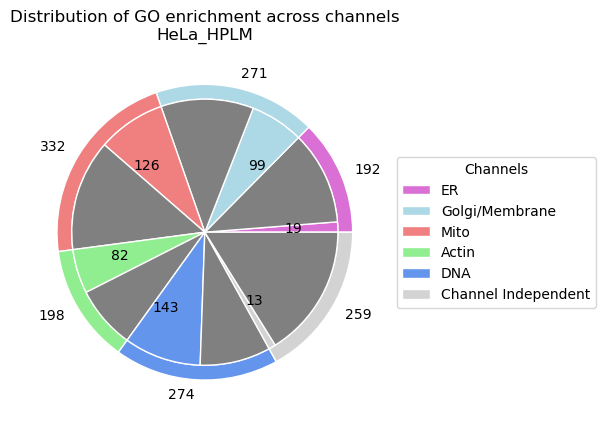

<Figure size 640x480 with 0 Axes>

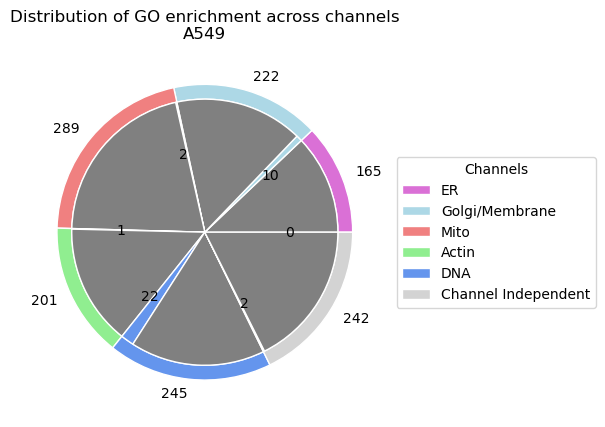

In [161]:
inner_colors = [None]*2*len(color_dict.values())
inner_colors[::2] = color_dict.values()
inner_colors[1::2] = ['grey']*len(color_dict.values())

for dataset, per_channel_dict in [
    ('HeLa_DMEM',per_channel_dict_HeLa_DMEM),
    ('HeLa_HPLM',per_channel_dict_HeLa_HPLM),
    ('A549',per_channel_dict_A549)
    ]:
       feat_set_num_list = list(per_channel_dict['feature_set_num'].values())
       enriched_num_list = list(per_channel_dict['enriched_num'].values())
       unenriched_num_list = []
       for x in range(len(feat_set_num_list)):
              unenriched_num_list.append(feat_set_num_list[x]-enriched_num_list[x])
       inner_pie = [None]*(len(enriched_num_list)+len(unenriched_num_list))
       inner_pie[::2] = enriched_num_list
       pie_labels = inner_pie.copy()
       inner_pie[1::2] = unenriched_num_list

       plt.clf()
       fig, ax = plt.subplots()

       wedges, texts = ax.pie(feat_set_num_list, radius=1, colors=color_dict.values(), labels=[str(x) for x in feat_set_num_list],
              wedgeprops=dict(width=.1, edgecolor='w'))
       ax.pie(inner_pie, radius=.9, colors=inner_colors, labels=pie_labels, labeldistance=.6,
              wedgeprops=dict(width=.9, edgecolor='w'))
       ax.set(aspect="equal", title=f'Distribution of GO enrichment across channels\n{dataset}')
       ax.legend(wedges, channel_dict.values(),
              title="Channels",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
       plt.savefig(os.path.join(output_folder,'figure_panels',f"Figure_6A_Channel_Distribution_of_GO_enrichment_{dataset}.png"),dpi=300,bbox_inches='tight')
       plt.show()

# Figure 5B, Extended Data 9B

In [104]:
group_color_dict = {'AreaShape':'saddlebrown', 'Correlation':'chocolate', 'Granularity':'peachpuff', 'Neighbors':'linen','Intensity':'indigo','RadialDistribution':'mediumorchid','Texture':'plum'}

def make_per_channel_group_dict(dataset, all_top_dict, GO_df):
    per_channel_group_dict = {'feature_set':{},'enriched':{},'feature_set_num':{},'enriched_num':{}}
    print (f"For dataset {dataset}")
    for group in group_color_dict.keys():
        list_in_feature_set = [x for x in all_top_dict.keys() if group.lower() in x.lower()]
        per_channel_group_dict['feature_set'][group] = list_in_feature_set
        per_channel_group_dict['feature_set_num'][group] = len(list_in_feature_set)
        list_enriched = list(GO_df.loc[GO_df['Feature'].str.contains(group)]['Feature'].unique())
        per_channel_group_dict['enriched'][group] = list_enriched
        per_channel_group_dict['enriched_num'][group] = len(list_enriched)
        print (f"There are {len(list_enriched)} {group} features with GO enrichment out of {len(list_in_feature_set)} in feature set")
    return per_channel_group_dict
per_channel_group_dict_HeLa_DMEM = make_per_channel_group_dict('HeLa_DMEM',all_top_dict_HeLa_DMEM,GO_df_HeLa_DMEM)
per_channel_group_dict_HeLa_HPLM = make_per_channel_group_dict('HeLa_HPLM',all_top_dict_HeLa_HPLM,GO_df_HeLa_HPLM)
per_channel_group_dict_A549 = make_per_channel_group_dict('A549',all_top_dict_A549,GO_df_A549)

For dataset HeLa_DMEM
There are 8 AreaShape features with GO enrichment out of 169 in feature set
There are 76 Correlation features with GO enrichment out of 233 in feature set
There are 21 Granularity features with GO enrichment out of 92 in feature set
There are 2 Neighbors features with GO enrichment out of 9 in feature set
There are 23 Intensity features with GO enrichment out of 62 in feature set
There are 36 RadialDistribution features with GO enrichment out of 191 in feature set
There are 370 Texture features with GO enrichment out of 1001 in feature set
For dataset HeLa_HPLM
There are 4 AreaShape features with GO enrichment out of 170 in feature set
There are 73 Correlation features with GO enrichment out of 258 in feature set
There are 16 Granularity features with GO enrichment out of 97 in feature set
There are 0 Neighbors features with GO enrichment out of 8 in feature set
There are 9 Intensity features with GO enrichment out of 72 in feature set
There are 26 RadialDistribut

<Figure size 640x480 with 0 Axes>

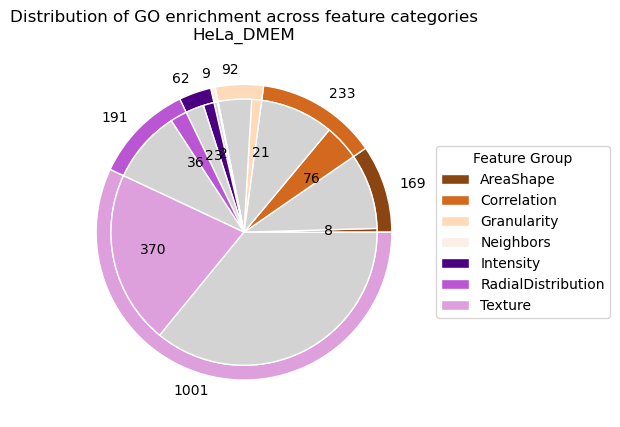

<Figure size 640x480 with 0 Axes>

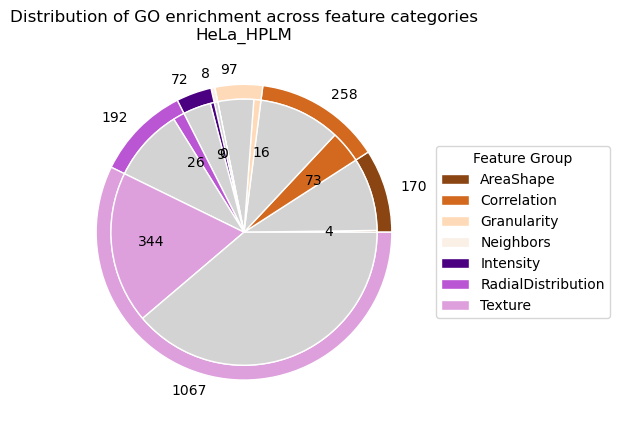

<Figure size 640x480 with 0 Axes>

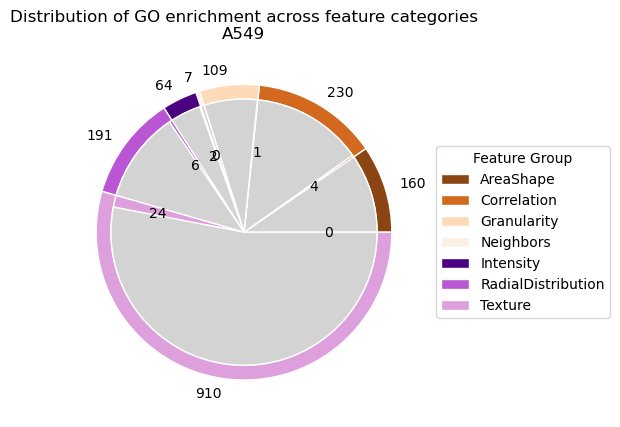

In [162]:
inner_colors = [None]*2*len(group_color_dict.values())
inner_colors[::2] = group_color_dict.values()
inner_colors[1::2] = ['lightgrey']*len(group_color_dict.values())

for dataset, group_dict in [
    ('HeLa_DMEM',per_channel_group_dict_HeLa_DMEM),
    ('HeLa_HPLM',per_channel_group_dict_HeLa_HPLM),
    ('A549',per_channel_group_dict_A549)
    ]:
       feat_set_num_list = list(group_dict['feature_set_num'].values())
       enriched_num_list = list(group_dict['enriched_num'].values())
       unenriched_num_list = []
       for x in range(len(group_color_dict)):
              unenriched_num_list.append(feat_set_num_list[x]-enriched_num_list[x])
       inner_pie = [None]*(len(enriched_num_list)+len(unenriched_num_list))
       inner_pie[::2] = enriched_num_list
       pie_labels = inner_pie.copy()
       inner_pie[1::2] = unenriched_num_list

       plt.clf()
       fig, ax = plt.subplots()

       wedges, texts = ax.pie(feat_set_num_list, radius=1, colors=group_color_dict.values(), labels=[str(x) for x in feat_set_num_list],
              wedgeprops=dict(width=.1, edgecolor='w'))
       ax.pie(inner_pie, radius=.9, colors=inner_colors, labels = pie_labels, labeldistance=.6,
              wedgeprops=dict(width=.9, edgecolor='w'))
       ax.set(aspect="equal", title=f'Distribution of GO enrichment across feature categories\n{dataset}')
       ax.legend(wedges, group_color_dict.keys(),
              title="Feature Group",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
       plt.savefig(os.path.join(output_folder,'figure_panels',f"Figure_6B_Feature_Category_Distribution_of_GO_enrichment_{dataset}.png"),dpi=300,bbox_inches='tight')
       plt.show()

# Figure 5C, Extended Data 9C

In [106]:
# As defined in SciPy 1.11.0
# We cannot import this directly from SciPy because it is not in the version (1.8.0) that we have in our environment
def false_discovery_control(ps, *, axis=0, method='bh'):

    # Input Validation and Special Cases
    ps = np.asarray(ps)

    ps_in_range = (np.issubdtype(ps.dtype, np.number)
                   and np.all(ps == np.clip(ps, 0, 1)))
    if not ps_in_range:
        raise ValueError("`ps` must include only numbers between 0 and 1.")

    methods = {'bh', 'by'}
    if method.lower() not in methods:
        raise ValueError(f"Unrecognized `method` '{method}'."
                         f"Method must be one of {methods}.")
    method = method.lower()

    if axis is None:
        axis = 0
        ps = ps.ravel()

    axis = np.asarray(axis)[()]
    if not np.issubdtype(axis.dtype, np.integer) or axis.size != 1:
        raise ValueError("`axis` must be an integer or `None`")

    if ps.size <= 1 or ps.shape[axis] <= 1:
        return ps[()]

    ps = np.moveaxis(ps, axis, -1)
    m = ps.shape[-1]

    # Main Algorithm

    # "Let [ps] be the ordered observed p-values..."
    order = np.argsort(ps, axis=-1)
    ps = np.take_along_axis(ps, order, axis=-1)  # this copies ps

    # Equation 1 of [1] rearranged to reject when p is less than specified q
    i = np.arange(1, m+1)
    ps *= m / i

    # Theorem 1.3 of [2]
    if method == 'by':
        ps *= np.sum(1 / i)

    # accounts for rejecting all null hypotheses i for i < k, where k is
    # defined in Eq. 1 of either [1] or [2]. See [3]. Starting with the index j
    # of the second to last element, we replace element j with element j+1 if
    # the latter is smaller.
    np.minimum.accumulate(ps[..., ::-1], out=ps[..., ::-1], axis=-1)

    # Restore original order of axes and data
    np.put_along_axis(ps, order, values=ps.copy(), axis=-1)
    ps = np.moveaxis(ps, -1, axis)

    return np.clip(ps, 0, 1)

In [127]:
with open("../../2022_PERISCOPE/common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)
with open("../../2022_PERISCOPE/Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    express = json.load(f)
    expressed_gene_list_HeLa = express['expressed_genes']
with open("../../2022_PERISCOPE/Hit_Calling/outputs/A549_CCLE_expression_summary.json") as f:
    express = json.load(f)
    expressed_gene_list_A549 = express['expressed_genes']

gene_group_dict = {'Vacuolar-type ATPase':'lightblue','Protein O-mannosylation':'orchid','Outer Mitochondrial Membrane Protein Complex':'lightcoral',
               'Cortical Cytoskeleton':'lightgreen','DNA Polymerase Complex':'cornflowerblue'}
gene_group_channel_dict = {'Vacuolar-type ATPase':'WGA','Protein O-mannosylation':'ConA','Outer Mitochondrial Membrane Protein Complex':'Mito',
               'Cortical Cytoskeleton':'Phalloidin','DNA Polymerase Complex':'DAPI'}

def make_gene_group_enrich(all_top_dict,expressed_gene_list):
    gene_group_enrich_df = pd.DataFrame(columns=['feature','gene_group','feature_category','p-value'])
    for feat in [x for x in all_top_dict if 'Correlation' not in x]:
        for gene_group in gene_group_dict.keys():
            entry_dict = {}
            entry_dict['feature'] = feat
            entry_dict['gene_group'] = gene_group

            group_genes = gene_set_dict[gene_group]
            feat_genes = all_top_dict[feat]
            group_genes_in_feat_genes = [x for x in group_genes if x in feat_genes]
            res = ss.fisher_exact([[len(group_genes_in_feat_genes),len(feat_genes)],[len(group_genes),len(expressed_gene_list)]],alternative='greater')
            entry_dict['p-value'] = res[1]

            if 'ConA' in feat:
                entry_dict['feature_category']='ConA'
            elif 'WGA' in feat:
                entry_dict['feature_category']='WGA'
            elif 'Mito' in feat:
                entry_dict['feature_category']='Mito'
            elif 'Phalloidin' in feat:
                entry_dict['feature_category']='Phalloidin'
            elif 'DAPI' in feat:
                entry_dict['feature_category']='DAPI'
            else:
                entry_dict['feature_category']='NoChannel'
                
            gene_group_enrich_df = pd.concat([gene_group_enrich_df,pd.DataFrame([entry_dict])])
            gene_group_enrich_df['p-value_bh'] = false_discovery_control(gene_group_enrich_df['p-value'], axis=0, method='bh')
    return gene_group_enrich_df

gene_group_enrich_df_HeLa_DMEM = make_gene_group_enrich(all_top_dict_HeLa_DMEM,expressed_gene_list_HeLa)
gene_group_enrich_df_HeLa_HPLM = make_gene_group_enrich(all_top_dict_HeLa_HPLM,expressed_gene_list_HeLa)
gene_group_enrich_df_A549 = make_gene_group_enrich(all_top_dict_A549,expressed_gene_list_A549)

HeLa_DMEM


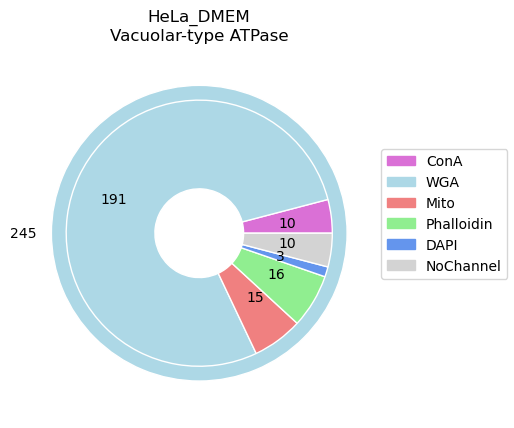

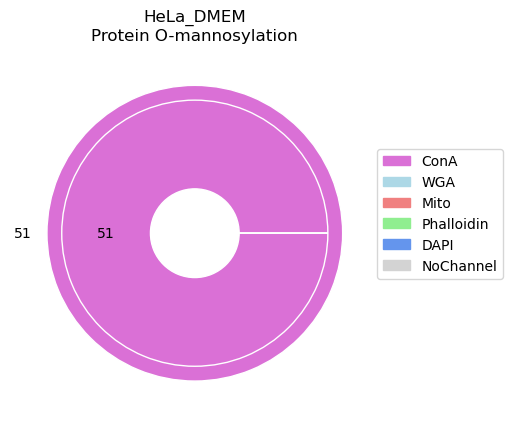

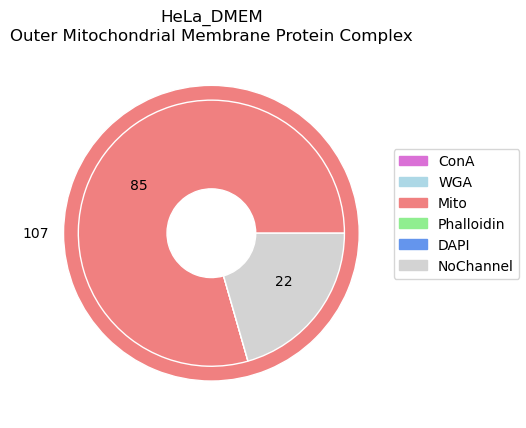

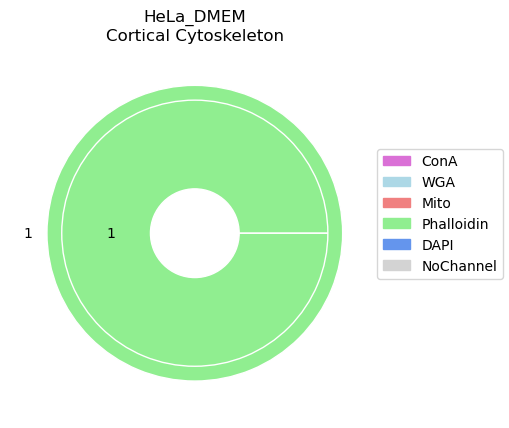

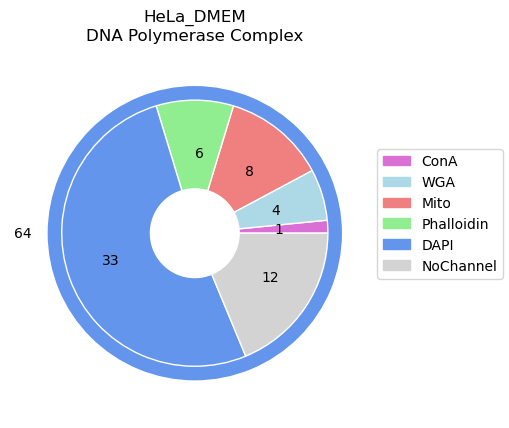

HeLa_HPLM


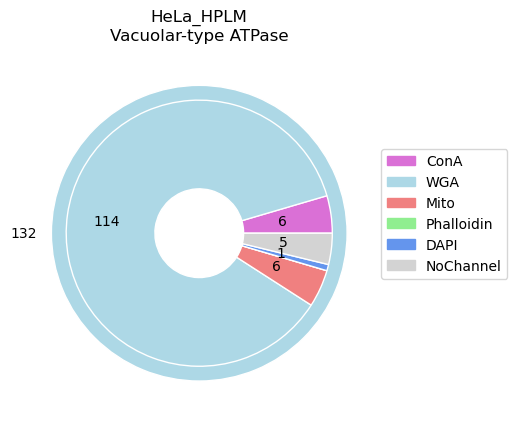

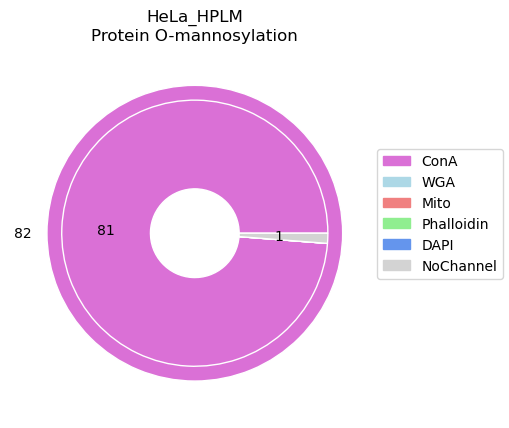

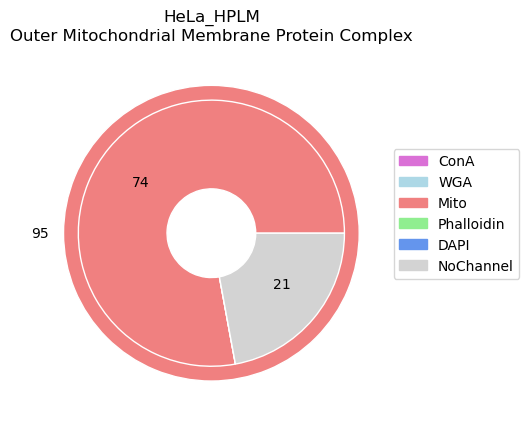

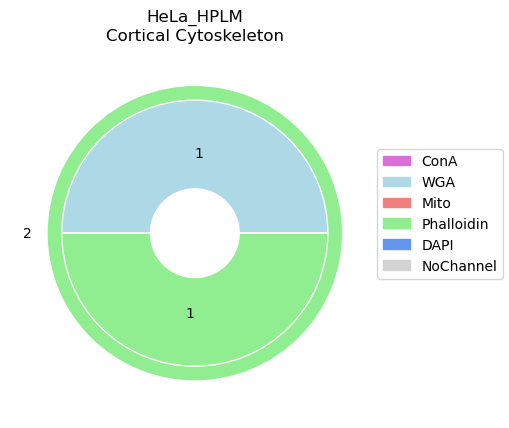

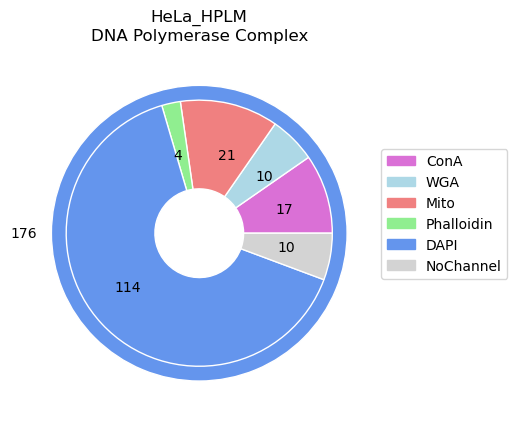

A549


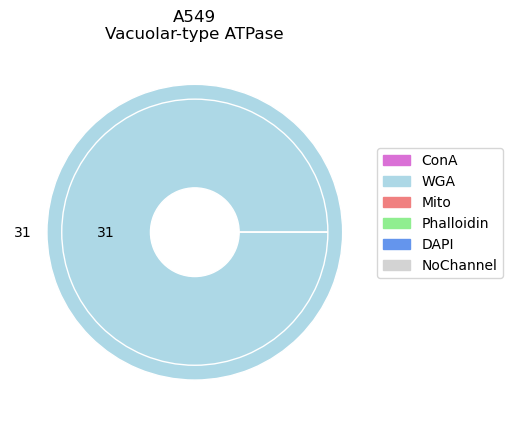

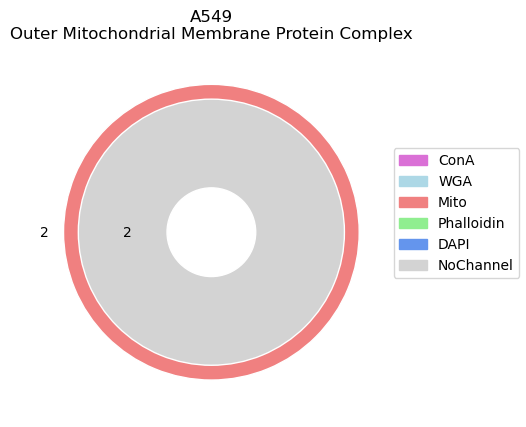

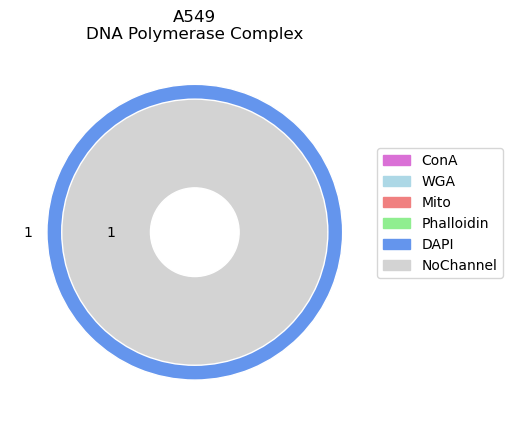

In [164]:
def make_hit_list(df):
       hit_list = []
       for feat_cat in channel_dict.keys():
              hit_list.append(len(df.loc[df['feature_category']==feat_cat]))
       return hit_list

for dataset, gene_group_enrich_df in [
       ('HeLa_DMEM',gene_group_enrich_df_HeLa_DMEM),
       ('HeLa_HPLM',gene_group_enrich_df_HeLa_HPLM),
       ('A549',gene_group_enrich_df_A549)]:
       print (dataset)
       gene_group_enrich_df_hits = gene_group_enrich_df.loc[gene_group_enrich_df['p-value_bh']<.05]
       for group in gene_group_dict.keys():
       #for channel, compartment in channel_dict.items():
              df = gene_group_enrich_df_hits.loc[gene_group_enrich_df_hits['gene_group']==group]
              hit_list = make_hit_list(df)
              if len(df) > 0 and sum(hit_list) > 0:
                     fig, ax = plt.subplots()
                     ax.pie([len(df)], radius=1, colors=[gene_group_dict[group]],labels = [len(df)],
                            wedgeprops=dict(width=.3, edgecolor='w'))
                     ax.pie(hit_list, radius=.9, colors=list(color_dict.values()),labels = [x if x != 0 else None for x in hit_list], labeldistance=.6,
                            wedgeprops=dict(width=.6, edgecolor='w'))
                     ax.set(aspect="equal", title=f'{dataset}\n{group}')

                     # Create figure legend
                     patch_list = []
                     for comp, color, in color_dict.items():
                            patch_list.append(mpatches.Patch(color=color, label=comp))
                     fig.legend(handles=patch_list,loc='center right')
                     
                     plt.savefig(os.path.join(output_folder,'figure_panels',f"Figure_6C_Specific_GO_enrichment_of_{group}_{dataset}.png"),dpi=300,bbox_inches='tight')
                     plt.show()

# Fig 5D and 5E, Extended Data 9D and 9E

In [3]:
# Load barcodes used in experiment
guide_df = pd.read_csv('../common_files/Barcodes.csv')
guide_list = guide_df['gene_symbol'].to_list()

In [7]:
# Load hit lists from experiments
HeLa_DMEM_comp_spec_hits = pd.read_csv('../3_HeLa_Screens_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_fdr_compartment_specific_hits.csv').set_index('Gene')
HeLa_DMEM_whole_cell_hits = pd.read_csv('../3_HeLa_Screens_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_fdr_whole_cell_hits.csv').set_index('Gene')
HeLa_DMEM_hit_list = list(HeLa_DMEM_comp_spec_hits.index) + list(HeLa_DMEM_whole_cell_hits.index)

HeLa_HPLM_comp_spec_hits = pd.read_csv('../3_HeLa_Screens_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_fdr_compartment_specific_hits.csv').set_index('Gene')
HeLa_HPLM_whole_cell_hits = pd.read_csv('../3_HeLa_Screens_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_fdr_whole_cell_hits.csv').set_index('Gene')
HeLa_HPLM_hit_list = list(HeLa_HPLM_comp_spec_hits.index) + list(HeLa_HPLM_whole_cell_hits.index)

A549_comp_spec_hits = pd.read_csv('../2_A549_Screen_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_1_fdr_compartment_specific_hits.csv').set_index('Gene')
A549_whole_cell_hits = pd.read_csv('../2_A549_Screen_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_1_fdr_whole_cell_hits.csv').set_index('Gene')
A549_hit_list = list(A549_comp_spec_hits.index) + list(A549_whole_cell_hits.index)

In [5]:
# Define features lists
WGA_Granularity_cols = ['Cells_Granularity_1_WGA','Cells_Granularity_2_WGA',
                'Cells_Granularity_3_WGA','Cells_Granularity_4_WGA',
                'Cells_Granularity_5_WGA','Cells_Granularity_6_WGA',
                'Cells_Granularity_7_WGA', 'Cells_Granularity_8_WGA']

# Create aggregated databases

Aggregation may be too computationally intensive for a standard personal computer.  
Skip aggregation by downloading aggregated files following instructions in README.md

## HeLa

In [ ]:
# Load normalized plate_level profiles, remove ghost guides, and merge 
DMEM_plates = ['CP257A','CP257B','CP257D','CP257F','CP257H']
HPLM_plates = ['CP257J','CP257K','CP257L','CP257N']

DMEM_list = []
for plate in DMEM_plates:
    filename = f'20210422_6W_CP257_guide_normalized_ALLBATCHES___{plate}___ALLWELLS.csv.gz'
    pre_DMEM_df = pd.read_csv(os.path.join(data_input_folder, filename))
    pre_DMEM_df = pre_DMEM_df[pre_DMEM_df["Metadata_Foci_Barcode_MatchedTo_Barcode"].isin(guide_list)]
    DMEM_list.append(pre_DMEM_df)

HeLa_DMEM_df = pd.concat(DMEM_list)

HPLM_list = []
for plate in HPLM_plates:
    filename = f'20210422_6W_CP257_guide_normalized_ALLBATCHES___{plate}___ALLWELLS.csv.gz'
    pre_HPLM_df = pd.read_csv(os.path.join(data_input_folder, filename))
    pre_HPLM_df = pre_HPLM_df[pre_HPLM_df["Metadata_Foci_Barcode_MatchedTo_Barcode"].isin(guide_list)]
    HPLM_list.append(pre_HPLM_df)

HeLa_HPLM_df = pd.concat(HPLM_list)

HeLa_DMEM_df.head()

In [ ]:
# Perform median aggregation on profiles
HeLa_DMEM_df = aggregate(
            population_df=HeLa_DMEM_df, 
            strata=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'], 
            features='infer', 
            operation='median' 
            )

HeLa_HPLM_df = aggregate(
            population_df=HeLa_HPLM_df, 
            strata=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'], 
            features='infer', 
            operation='median' 
            )
            
HeLa_DMEM_df.to_csv(os.path.join(output_folder,'20210422_6W_CP257_guide_normalized_median_merged_ALLBATCHES___DMEM___ALLWELLS.csv', index=False))
HeLa_HPLM_df.to_csv(os.path.join(output_folder,'20210422_6W_CP257_guide_normalized_median_merged_ALLBATCHES___HPLM___ALLWELLS.csv', index=False))
HeLa_DMEM_df.head()

In [ ]:
# Create and save Granularity subsetted versions to simplify data handling
HeLa_DMEM_WGA_Granularity_df = HeLa_DMEM_df[WGA_Granularity_cols+['Metadata_Foci_Barcode_MatchedTo_GeneCode']]
HeLa_HPLM_WGA_Granularity_df = HeLa_HPLM_df[WGA_Granularity_cols+['Metadata_Foci_Barcode_MatchedTo_GeneCode']]

HeLa_DMEM_WGA_Granularity_df.to_csv(os.path.join(output_folder,'HeLa_DMEM_WGA_Granularity_features_only.csv'), index=False)
HeLa_HPLM_WGA_Granularity_df.to_csv(os.path.join(output_folder,'HeLa_HPLM_WGA_Granularity_features_only.csv'), index=False)


## A549

In [ ]:
# Load normalized plate_level profiles, remove ghost guides, and merge 
plates = ['CP186','CP186B','CP186C','CP186D','CP186E','CP186F','CP186G','CP186H','CP186N']

A549_list = []
for plate in plates:
    filename = f'20210422_6W_CP257_guide_normalized_ALLBATCHES___{plate}___ALLWELLS.csv.gz'
    pre_df = pd.read_csv(os.path.join(data_input_folder, filename))
    pre_df = pre_df[pre_df["Metadata_Foci_Barcode_MatchedTo_Barcode"].isin(guide_list)]
    A549_list.append(pre_df)

A549_df = pd.concat(A549_list)
A549_df.head()

In [ ]:
# Perform median aggregation on profiles
A549_df= aggregate(
            population_df=A549_df, 
            strata=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'], 
            features='infer', 
            operation='median' 
            )

A549_df.to_csv(os.path.join(data_input_folder,'20200805_A549_WG_Screen_guide_normalized_median_merged_ALLBATCHES_ALLWELLS', index=False))
A549_df.head()

In [ ]:
# Create and save Granularity subsetted versions to simplify data handling
A549_WGA_Granularity_df = A549_df[WGA_Granularity_cols+['Metadata_Foci_Barcode_MatchedTo_GeneCode']]
A549_WGA_Granularity_df.to_csv(os.path.join(output_folder,'A549_WGA_Granularity_features_only.csv'), index=False)

# WGA Granularity

In [10]:
# Load aggregated files if not running notebook straight through
# You can skip this loading if you have just created the aggregated database in previous cells

HeLa_HPLM_WGA_Granularity_df = pd.read_csv(os.path.join(output_folder, 'HeLa_HPLM_WGA_Granularity_features_only.csv'))
HeLa_DMEM_WGA_Granularity_df = pd.read_csv(os.path.join(output_folder, 'HeLa_DMEM_WGA_Granularity_features_only.csv'))
A549_WGA_Granularity_df = pd.read_csv(os.path.join(output_folder, 'A549_WGA_Granularity_features_only.csv'))


In [11]:
V1 = ['ATP6V1A', 'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2', 
        'ATP6V1G1', 'ATP6V1G2', 'ATP6V1G3', 'ATP6V1F', 'ATP6V1H']
V0 = ['ATP6V0A1', 'ATP6V0A2', 'ATP6V0A4', 'ATP6V0B', 'ATP6V0C', 'ATP6V0D1', 'ATP6V0D2', 
      'ATP6V0E1', 'ATP6V0E2', 'ATP6AP1', 'ATP6AP2', 'RNASEK', 'ATP6V0A3','TCIRG1']
Assembly = ['ALDOB', 'CCDC115', 'VMA21', 'TMEM199', 'TM9SF4'] # none are hits in these screens

genelist = V1 + V0 + Assembly + ['nontargeting']

HeLa_HPLM_WGA_Granularity_df = HeLa_HPLM_WGA_Granularity_df[HeLa_HPLM_WGA_Granularity_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genelist)]
HeLa_HPLM_WGA_Granularity_meandf = HeLa_HPLM_WGA_Granularity_df.groupby(['Metadata_Foci_Barcode_MatchedTo_GeneCode']).mean().reset_index()

HeLa_DMEM_WGA_Granularity_df = HeLa_DMEM_WGA_Granularity_df[HeLa_DMEM_WGA_Granularity_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genelist)]
HeLa_DMEM_WGA_Granularity_meandf = HeLa_DMEM_WGA_Granularity_df.groupby(['Metadata_Foci_Barcode_MatchedTo_GeneCode']).mean().reset_index()

A549_WGA_Granularity_df = A549_WGA_Granularity_df[A549_WGA_Granularity_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genelist)]
A549_WGA_Granularity_meandf = A549_WGA_Granularity_df.groupby(['Metadata_Foci_Barcode_MatchedTo_GeneCode']).mean().reset_index()

for meandf,screen in [(HeLa_HPLM_WGA_Granularity_meandf,'HeLa_HPLM'), (HeLa_DMEM_WGA_Granularity_meandf,'HeLa_DMEM'), (A549_WGA_Granularity_meandf,'A549')]:
    for row in meandf['Metadata_Foci_Barcode_MatchedTo_GeneCode']:
        if row in V0:
            meandf.loc[meandf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Subunit'] = 'V0'
        if row in V1:
            meandf.loc[meandf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Subunit'] = 'V1'
        if row in Assembly:
            meandf.loc[meandf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Subunit'] = 'Assembly'
        if row == 'nontargeting':
            meandf.loc[meandf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Subunit'] = 'Control'
    meandf = meandf.astype({'Subunit': 'category','Metadata_Foci_Barcode_MatchedTo_GeneCode': 'category'})
    meandf.to_csv(os.path.join(output_folder,f'{screen}_WGA_Granularity_annotated.csv'), index=False)

HeLa_HPLM_WGA_Granularity_meandf.head()

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Cells_Granularity_1_WGA,Cells_Granularity_2_WGA,Cells_Granularity_3_WGA,Cells_Granularity_4_WGA,Cells_Granularity_5_WGA,Cells_Granularity_6_WGA,Cells_Granularity_7_WGA,Cells_Granularity_8_WGA,Subunit
0,ALDOB,-0.447338,0.357686,-0.020960,-0.292061,-0.419399,0.213564,0.163909,0.235526,Assembly
1,ATP6AP1,-0.151619,0.450786,0.222052,-0.098751,0.274049,0.294694,0.247055,-0.055196,V0
2,ATP6AP2,0.007554,-0.030180,0.075321,-0.019468,-0.068548,-0.251546,-0.310216,-0.507260,V0
3,ATP6V0A1,-0.231419,-0.234220,0.098330,-0.254492,0.056772,0.079203,-0.026426,0.375781,V0
4,ATP6V0A2,0.058131,-0.064871,0.065942,-0.175694,0.025813,-0.171291,-0.453497,-0.273113,V0


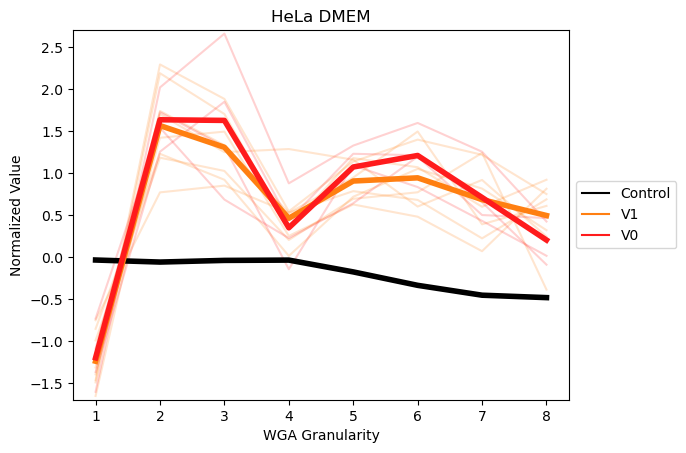

In [24]:
ecdfdf = HeLa_DMEM_WGA_Granularity_meandf.melt(id_vars=['Metadata_Foci_Barcode_MatchedTo_GeneCode', 'Subunit'])
ecdfdf['variable'] = ecdfdf['variable'].str.split('_').str[2]
for row in ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']:
    if row in HeLa_DMEM_hit_list:
        ecdfdf.loc[ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Screen_Hit'] = 'True'
    elif row == 'nontargeting':
        ecdfdf.loc[ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Screen_Hit'] = 'True'
ecdfdf = ecdfdf.dropna(axis='index', subset='Screen_Hit')

plt.clf()
g = sns.lineplot(x="variable", y="value",
                 hue="Subunit", hue_order=['Control','V1','V0'], 
                 palette=["black","#ff7f11","#ff1b1c"], alpha=.2,
                 units='Metadata_Foci_Barcode_MatchedTo_GeneCode', estimator=None, 
                 data=ecdfdf)
sns.lineplot(x="variable", y="value", hue="Subunit", errorbar=None, linewidth=4,
                 hue_order=['Control','V1','V0'], palette=["black","#ff7f11","#ff1b1c"],
                 data=ecdfdf,legend=False)
g.set_xlabel("WGA Granularity")
g.set_ylabel("Normalized Value")
g.set(ylim=(-1.7,2.7))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.set_title('HeLa DMEM')
plt.savefig(os.path.join(output_folder,'figure_panels','HeLa_DMEM_WGA_ecdf_plot.png'), dpi=1200,bbox_inches='tight')
plt.show()

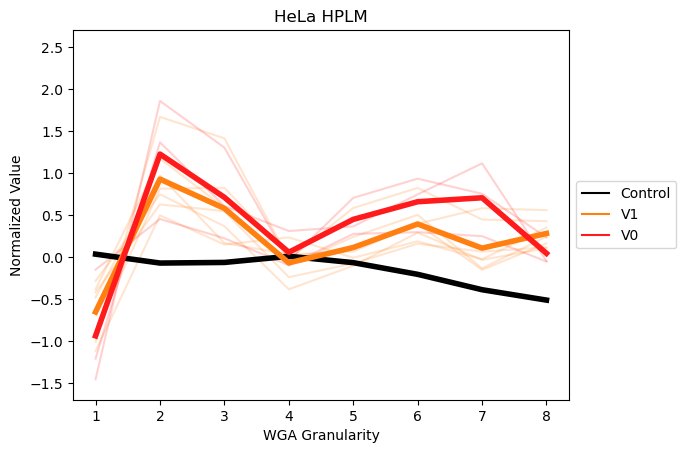

In [25]:
ecdfdf = HeLa_HPLM_WGA_Granularity_meandf.melt(id_vars=['Metadata_Foci_Barcode_MatchedTo_GeneCode', 'Subunit'])
ecdfdf['variable'] = ecdfdf['variable'].str.split('_').str[2]
for row in ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']:
    if row in HeLa_HPLM_hit_list:
        ecdfdf.loc[ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Screen_Hit'] = 'True'
    elif row == 'nontargeting':
        ecdfdf.loc[ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Screen_Hit'] = 'True'
ecdfdf = ecdfdf.dropna(axis='index', subset='Screen_Hit')

plt.clf()
g = sns.lineplot(x="variable", y="value",
                 hue="Subunit", hue_order=['Control','V1','V0'], 
                 palette=["black","#ff7f11","#ff1b1c"], alpha=.2,
                 units='Metadata_Foci_Barcode_MatchedTo_GeneCode', estimator=None, 
                 data=ecdfdf)
sns.lineplot(x="variable", y="value", hue="Subunit", errorbar=None, linewidth=4,
                 hue_order=['Control','V1','V0'], palette=["black","#ff7f11","#ff1b1c"],
                 data=ecdfdf,legend=False)

g.set_xlabel("WGA Granularity")
g.set_ylabel("Normalized Value")
g.set(ylim=(-1.7,2.7))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.set_title('HeLa HPLM')
plt.savefig(os.path.join(output_folder,'figure_panels','HeLa_HPLM_WGA_ecdf_plot.png'), dpi=1200,bbox_inches='tight')
plt.show()

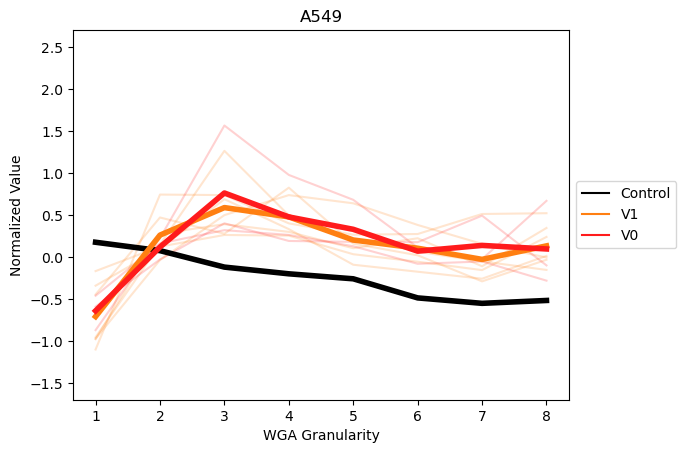

In [26]:
ecdfdf = A549_WGA_Granularity_meandf.melt(id_vars=['Metadata_Foci_Barcode_MatchedTo_GeneCode', 'Subunit'])
ecdfdf['variable'] = ecdfdf['variable'].str.split('_').str[2]
for row in ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']:
    if row in A549_hit_list:
        ecdfdf.loc[ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Screen_Hit'] = 'True'
    elif row == 'nontargeting':
        ecdfdf.loc[ecdfdf['Metadata_Foci_Barcode_MatchedTo_GeneCode']==row, 'Screen_Hit'] = 'True'
ecdfdf = ecdfdf.dropna(axis='index', subset='Screen_Hit')

plt.clf()
g = sns.lineplot(x="variable", y="value",
                 hue="Subunit", hue_order=['Control','V1','V0'], 
                 palette=["black","#ff7f11","#ff1b1c"], alpha=.2,
                 units='Metadata_Foci_Barcode_MatchedTo_GeneCode', estimator=None, 
                 data=ecdfdf)
sns.lineplot(x="variable", y="value", hue="Subunit", errorbar=None, linewidth=4,
                 hue_order=['Control','V1','V0'], palette=["black","#ff7f11","#ff1b1c"],
                 data=ecdfdf,legend=False)

g.set_xlabel("WGA Granularity")
g.set_ylabel("Normalized Value")
g.set(ylim=(-1.7,2.7))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.set_title('A549')
plt.savefig(os.path.join(output_folder,'figure_panels','A549_WGA_ecdf_plot.png'), dpi=1200,bbox_inches='tight')
plt.show()

# Visualize Granularity
# Figure 5F & 5G, Extended Data 9F & 9G

In [16]:
%matplotlib inline
import numpy
import skimage
import skimage.morphology 
import scipy
import matplotlib.pyplot as plt
from imageio import imread
import os

In [17]:
# subfactor = "Subsampling factor for granularity measurements"
# samp_size = "Subsampling factor for background reduction"
# radius = "Radius of structuring element"
# eros = "Range of the granular spectrum"

def show_granularity_result(figname, pixels,subfactor,samp_size,radius,eros, viewscale=1, outputseparate=False):
    # Rescale image 
    orig = pixels.copy()
    
    new_shape = numpy.array(pixels.shape)
    new_shape = new_shape * subfactor
    i, j = (
        numpy.mgrid[0 : new_shape[0], 0 : new_shape[1]].astype(float)
        / subfactor
    )
    pixels = scipy.ndimage.map_coordinates(pixels, (i, j), order=1)

    mask = numpy.ones_like(pixels)
    prepixels = pixels.copy()
    
    # Do initial processing based on radius
    back_shape = new_shape * samp_size
    i, j = (
        numpy.mgrid[0 : back_shape[0], 0 : back_shape[1]].astype(float)
        / samp_size
    )
    back_pixels = scipy.ndimage.map_coordinates(pixels, (i, j), order=1)
    back_mask = (
        scipy.ndimage.map_coordinates(mask.astype(float), (i, j)) > 0.9
    )

    # "Radius of structuring element"
    selem = skimage.morphology.disk(radius, dtype=bool)
    back_pixels_mask = numpy.zeros_like(back_pixels)
    back_pixels_mask[back_mask == True] = back_pixels[back_mask == True]
    back_pixels = skimage.morphology.erosion(back_pixels_mask, footprint=selem)
    back_pixels_mask = numpy.zeros_like(back_pixels)
    back_pixels_mask[back_mask == True] = back_pixels[back_mask == True]
    back_pixels = skimage.morphology.dilation(back_pixels_mask, footprint=selem)
    i, j = numpy.mgrid[0 : new_shape[0], 0 : new_shape[1]].astype(float)
    #
    # Make sure the mapping only references the index range of
    # back_pixels.
    #
    i *= float(back_shape[0] - 1) / float(new_shape[0] - 1)
    j *= float(back_shape[1] - 1) / float(new_shape[1] - 1)
    back_pixels = scipy.ndimage.map_coordinates(
        back_pixels, (i, j), order=1
    )
    pixels -= back_pixels
    pixels[pixels < 0] = 0
    
    ero = pixels.copy()

    footprint = skimage.morphology.disk(1, dtype=bool)

    plt.clf()
    fig, axes = plt.subplots(ncols=eros+2, figsize=(16,8))
    ax = axes.ravel()
    ax[0].imshow(orig,cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')
    
    ax[1].imshow(pixels,cmap='gray')
    ax[1].set_title('Downscaled')
    ax[1].axis('off')


    for count in range(0,eros):
        prev_ero = ero
        count +=1
        ero_mask = numpy.zeros_like(ero)
        ero_mask[mask == True] = ero[mask == True]
        ero = skimage.morphology.erosion(ero_mask, footprint=footprint)
        # show what has been eroded
        ax[count+1].imshow(prev_ero - ero,cmap='gray',vmax=pixels.max()*viewscale, vmin=0)
        ax[count+1].set_title(f'Granularity {count}')
        ax[count+1].axis('off')
        if outputseparate:
            skimage.io.imsave(os.path.join(output_folder, f'{figname}_ero_{count}.tif'), ero)
    
    plt.savefig(os.path.join(output_folder,'figure_panels', figname), dpi=1200)

/var/folders/hl/5b1z8zzj1710zl1_g94wkycc0000gp/T/ipykernel_40394/362517409.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(image_input_folder,'CorrWGA_Site_17_sc1.tif'))


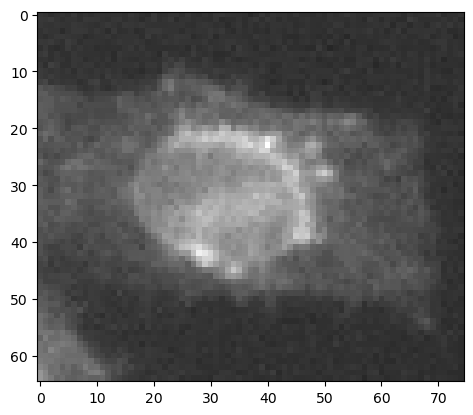

In [18]:
image = imread(os.path.join(image_input_folder,'CorrWGA_Site_17_sc1.tif'))
image = skimage.util.img_as_float(image)
pixels = image.copy()

plt.imshow(image, cmap='gray', vmax=pixels.max(), vmin=0)
plt.show()

/var/folders/hl/5b1z8zzj1710zl1_g94wkycc0000gp/T/ipykernel_40394/307666763.py:80: UserWarning: outputs/WGA_granularity_ero_1.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_folder, f'{figname}_ero_{count}.tif'), ero)
/var/folders/hl/5b1z8zzj1710zl1_g94wkycc0000gp/T/ipykernel_40394/307666763.py:80: UserWarning: outputs/WGA_granularity_ero_2.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_folder, f'{figname}_ero_{count}.tif'), ero)
/var/folders/hl/5b1z8zzj1710zl1_g94wkycc0000gp/T/ipykernel_40394/307666763.py:80: UserWarning: outputs/WGA_granularity_ero_3.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_folder, f'{figname}_ero_{count}.tif'), ero)
/var/folders/hl/5b1z8zzj1710zl1_g94wkycc0000gp/T/ipykernel_40394/307666763.py:80: UserWarning: outputs/WGA_granularity_ero_4.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_folder, f'{figname}_ero_{count}.tif'), ero)
/var/folders/hl/5b1z8zzj1710zl1_g94wkycc0000gp/T/ipy

<Figure size 640x480 with 0 Axes>

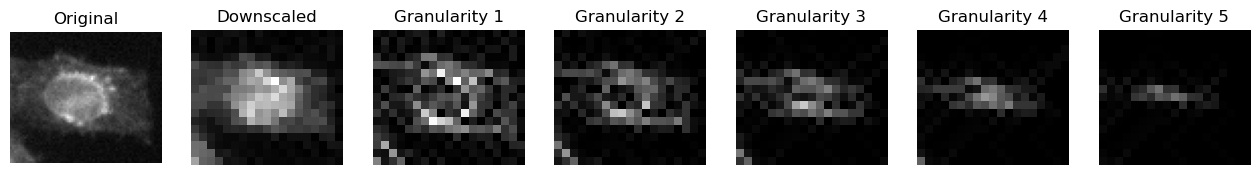

In [19]:
show_granularity_result('WGA_granularity', pixels,.25,.25,10,5, viewscale=.5, outputseparate=True)